## Računalni vid: 2. laboratorijska vježba

In [566]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

plt.gray()

<Figure size 432x288 with 0 Axes>

### Zadatak 1: Harrisov detektor kutova

#### 1.1 Učitavanje slike

In [567]:
fer_logo_original = np.array(Image.open('./fer_logo.jpg'))
house_original = np.array(Image.open('./house.jpg'))

# tensor dimensions
print(f'fer_logo tensor dimensions: {fer_logo_original.shape}')
print(f'   house tensor dimensions: {house_original.shape} \n')

fer_logo tensor dimensions: (419, 672)
   house tensor dimensions: (512, 512) 



In [568]:
# min, max intensity
print(f'fer_logo minimum intensity: {np.min(fer_logo_original)}')
print(f'fer_logo maximum intensity: {np.max(fer_logo_original)} \n')

print(f'   house minimum intensity: {np.min(house_original)}')
print(f'   house maximum intensity: {np.max(house_original)}')

fer_logo minimum intensity: 0
fer_logo maximum intensity: 255 

   house minimum intensity: 0
   house maximum intensity: 255


In [569]:
# upper left corner intensities
print('fer_logo upper left corner:')
print(fer_logo_original[:10, :10], '\n')

print('   house upper left corner:')
print(house_original[:10, :10])

fer_logo upper left corner:
[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]] 

   house upper left corner:
[[203 203 203 203 203 203 203 203 203 203]
 [203 203 203 203 203 203 203 203 203 203]
 [204 204 204 204 204 204 204 204 204 204]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]]


In [570]:
# data types
print(f'    fer_logo current data type: {fer_logo_original.dtype}')
fer_logo_original = fer_logo_original.astype(np.float32)
print(f'fer_logo transformed data type: {fer_logo_original.dtype}\n')

print(f'    house current data type: {house_original.dtype}')
house_original = house_original.astype(np.float32)
print(f'house transformed data type: {house_original.dtype}\n')

    fer_logo current data type: uint8
fer_logo transformed data type: float32

    house current data type: uint8
house transformed data type: float32



#### 1.2. Gaussovo zaglađivanje

In [571]:
def plot_5_smooth_images(sigma, img):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, s in enumerate(sigma):
        axs[i].imshow(gaussian_filter(img, sigma=s), cmap='gray')
        axs[i].set_title(f'$\sigma$ = {s}')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.suptitle('Images with gaussian filter applied')
    plt.show()

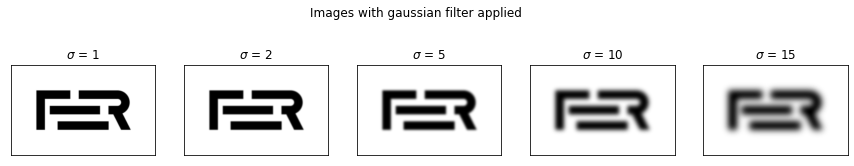

In [572]:
# gaussian smoothing
sigma = [1, 2, 5, 10, 15]
plot_5_smooth_images(sigma, fer_logo_original)

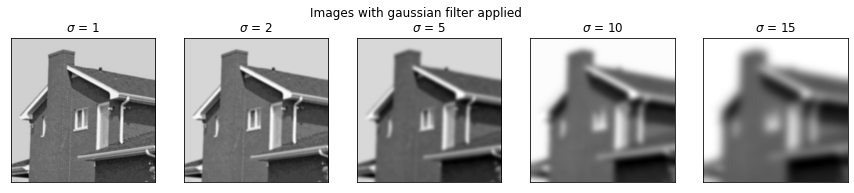

In [573]:
plot_5_smooth_images(sigma, house_original)

In [574]:
FER_SIGMA = 1
FER_THRESHOLD = 1e10
FER_K = 0.04
FER_TOP_K = 100
FER_SUM_W = 5
FER_NMS_W = 14

HOUSE_SIGMA = 1.5
HOUSE_THRESHOLD = 1e9
HOUSE_K = 0.04
HOUSE_TOP_K = 100
HOUSE_SUM_W = 5
HOUSE_NMS_W = 32

In [575]:
fer_logo = gaussian_filter(fer_logo_original, sigma=FER_SIGMA)

house = gaussian_filter(house_original, sigma=HOUSE_SIGMA)

#### 1.3. Izračun gradijenta

In [576]:
#I_x_conv = np.array([
#    [ -1, 0, 1],
#    [ -2, 0, 2],
#    [ -1, 0, 1]
#])

I_x_conv = np.array([
    [ 1,  0, -1],
    [ 2,  0, -2],
    [ 1,  0, -1]
])
I_y_conv = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
])

def calculate_gradient_and_plot(img, I_x_conv=I_x_conv, I_y_conv=I_y_conv, plot=True):
    img_x_grad = convolve(img, weights=I_x_conv)
    img_y_grad = convolve(img, weights=I_y_conv)
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img_x_grad)
        axs[0].set_title('Gradient of x axis')
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[1].imshow(img_y_grad)
        axs[1].set_title('Gradient of y axis')
        axs[1].set_xticks([])
        axs[1].set_yticks([])
    return img_x_grad, img_y_grad

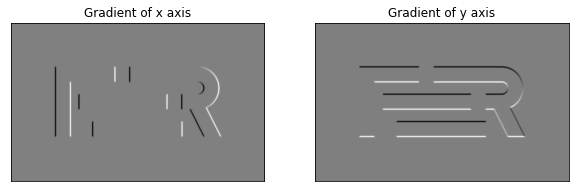

In [577]:
# image gradients
fer_logo_x_grad, fer_logo_y_grad = calculate_gradient_and_plot(fer_logo)

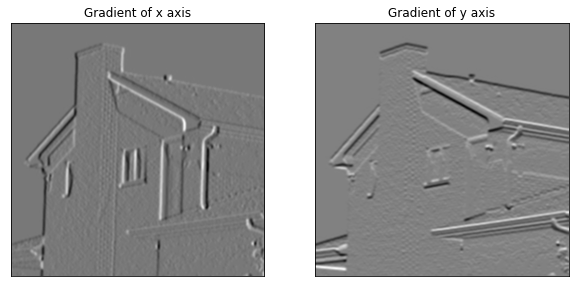

In [578]:
house_x_grad, house_y_grad = calculate_gradient_and_plot(house)

In [579]:
# second moments of gradients
def calculate_second_moments(x_grad, y_grad):
    x_grad_2 = x_grad**2
    y_grad_2 = y_grad**2
    x_y_grad = x_grad * y_grad
    return x_grad_2, y_grad_2, x_y_grad

In [580]:
fer_logo_x_grad_2, fer_logo_y_grad_2, fer_logo_x_y_grad = calculate_second_moments(
    fer_logo_x_grad, fer_logo_y_grad
) 

house_x_grad_2, house_y_grad_2, house_x_y_grad = calculate_second_moments(
    house_x_grad, house_y_grad
)

#### 1.4. Sumiranje gradijenata u lokalnom susjedstvu

In [581]:
def calculate_characteristic_matrix(img, I_x_2, I_y_2, I_x_y, w):
    conv_mask = np.ones(shape=(w, w))
    I_x_2_c = convolve(I_x_2, weights=conv_mask)
    I_y_2_c = convolve(I_y_2, weights=conv_mask)
    I_x_y_c = convolve(I_x_y, weights=conv_mask)
    
    characteristic = np.empty(shape=(img.shape[0], img.shape[1], 2, 2))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            characteristic[i, j] = [
                [I_x_2_c[i, j], I_x_y_c[i, j]],
                [I_x_y_c[i, j], I_y_2_c[i, j]],
            ]
    return characteristic

In [582]:
fer_logo_characteristic = calculate_characteristic_matrix(
    fer_logo, fer_logo_x_grad_2, fer_logo_y_grad_2, fer_logo_x_y_grad, FER_SUM_W
)

house_characteristic = calculate_characteristic_matrix(
    house, house_x_grad_2, house_y_grad_2, house_x_y_grad, HOUSE_SUM_W
)

print(fer_logo_characteristic.shape)
print(house_characteristic.shape)

(419, 672, 2, 2)
(512, 512, 2, 2)


#### 1.5. Izračun Harrisovog odziva

In [583]:
def calculate_harris_recall(img, characteristic, k):
    r = np.empty(shape=img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            a = characteristic[i, j][0, 0]
            b = characteristic[i, j][1, 1]
            c = characteristic[i, j][0, 1]
            r[i, j] = a*b - c**2 - k*((a+b)**2)
    return r

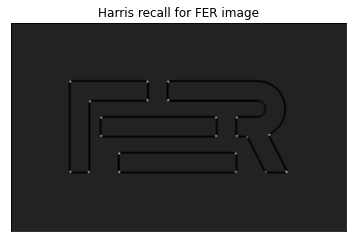

In [584]:
fer_logo_r = calculate_harris_recall(fer_logo, fer_logo_characteristic, FER_K)

plt.imshow(fer_logo_r)
plt.xticks([])
plt.yticks([])
plt.title('Harris recall for FER image')
plt.show()

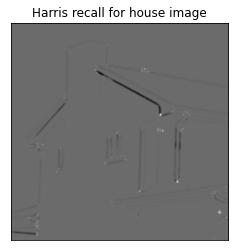

In [585]:
house_r = calculate_harris_recall(house, house_characteristic, HOUSE_K)

plt.imshow(house_r)
plt.xticks([])
plt.yticks([])
plt.title('Harris recall for house image')
plt.show()

#### 1.6. Potiskivanje nemaksimalnih odziva

In [586]:
def suppress_nonmaximal_recalls(r, threshold, k):
    r[r < threshold] = 0
    r_tmp = r.copy()
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            l0, l1 = max(0, i - k//2), min(r.shape[0], i + k//2 + (k % 2 == 1)) 
            h0, h1 = max(0, j - k//2), min(r.shape[1], j + k//2 + (k % 2 == 1))
            if r[i, j] < r[l0:l1, h0:h1].max():
                r_tmp[i, j] = 0
    return r_tmp

In [587]:
fer_logo_r = suppress_nonmaximal_recalls(fer_logo_r, FER_THRESHOLD, FER_NMS_W)

house_r = suppress_nonmaximal_recalls(house_r, HOUSE_THRESHOLD, HOUSE_NMS_W)

#### 1.7. Selektiranje k-najvećih odziva

In [588]:
def select_k_best_recalls(recalls, top_k):
    x, y = np.nonzero(recalls)
    return x[:top_k], y[:top_k]

def draw_image_with_best_recalls(original_img, x, y):
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.scatter(y, x, s=50, facecolors='none', edgecolors='r')
    plt.xticks([])
    plt.yticks([])
    plt.title('Image with best recalls')
    plt.show()

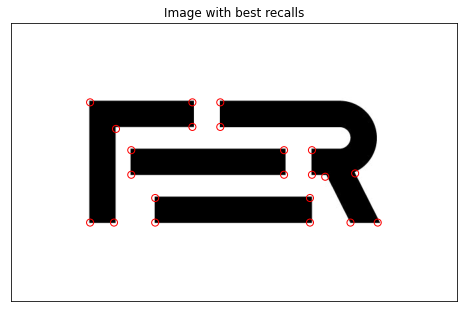

In [589]:
x_fer, y_fer = select_k_best_recalls(fer_logo_r, FER_TOP_K)

draw_image_with_best_recalls(fer_logo_original, x_fer, y_fer)

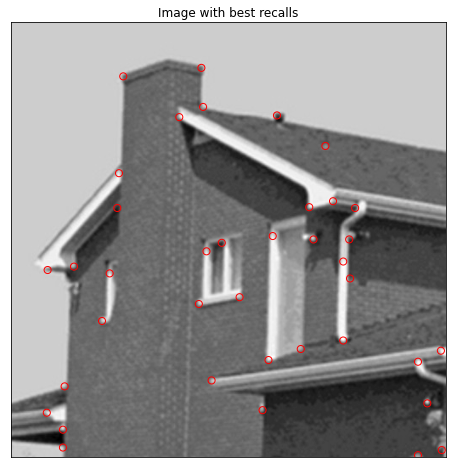

In [590]:
x_house, y_house = select_k_best_recalls(house_r, HOUSE_TOP_K)

draw_image_with_best_recalls(house_original, x_house, y_house)

### Zadatak 2: Cannyev detektor rubova

#### 2.1 Učitavanje slike

In [591]:
house_original = np.array(Image.open('./house.jpg'))

#### 2.2. Gaussovo zaglađivanje

In [592]:
HOUSE_SIGMA = 1.5
HOUSE_MIN_VAL = 10
HOUSE_MAX_VAL = 90

In [593]:
house = gaussian_filter(house, sigma=HOUSE_SIGMA)

#### 2.3. Izračun gradijenata

In [594]:
house_x_grad, house_y_grad = calculate_gradient_and_plot(
    house, I_x_conv, I_y_conv, plot=False
)

#### 2.4. Izračun magnitude i kuta gradijenta

In [595]:
def calculate_grad_magnitude_and_angle(x_grad, y_grad):
    return np.hypot(x_grad, y_grad), np.arctan2(y_grad, x_grad)

def normalize_magnitude(magnitude):
    return (magnitude/magnitude.max()) * 255.

def visualize_grad_magnitude(magnitude, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(magnitude)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
magnitude, angle = calculate_grad_magnitude_and_angle(house_x_grad, house_y_grad)
magnitude = normalize_magnitude(magnitude)

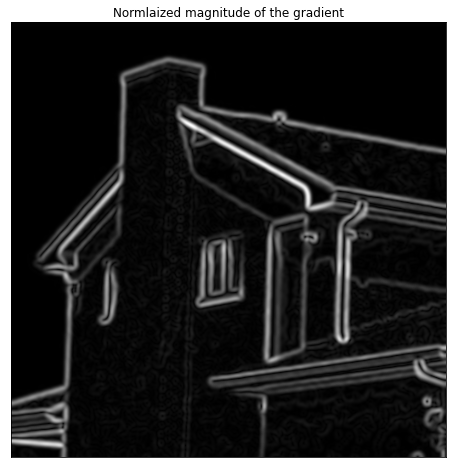

In [596]:
visualize_grad_magnitude(magnitude, title='Normlaized magnitude of the gradient')

#### 2.5. Potiskivanje nemaksimalnih odziva

In [597]:
def suppress_nonmaximal_recalls2(magnitude, angle, radians=True):
    if radians:
        angle = np.degrees(angle)
    
    x_max, y_max = angle.shape
    set_boundary = lambda x, m: max(min(x, m-1), 0) 
    magnitude2 = magnitude.copy()
    for i in range(angle.shape[0]):
        for j in range(angle.shape[1]):
            
            a = angle[i, j]
            
            if (-22.5 < a < 22.5) or (a > 157.5) or (a < -157.5):
                l, h = (i, j-1), (i, j+1)
            
            elif (22.5 < a < 67.5) or (-157.5 < a < -112.5):
                l, h = (i-1, j-1), (i+1, j+1)
            
            elif (67.5 < a < 112.5) or (-112.5 < a < -67.5):
                l, h = (i-1, j), (i+1, j)
                
            elif (-67.5 < a < -22.5) or (112.5 < a < 157.5):
                l, h = (i+1, j-1), (i-1, j+1)
                
            neighbors = [
                magnitude[set_boundary(l[0], x_max), set_boundary(l[1], y_max)],
                magnitude[set_boundary(h[0], x_max), set_boundary(h[1], y_max)]
            ]

            if not (magnitude[i, j] > neighbors).all():
                magnitude2[i, j] = 0
                
    return magnitude2

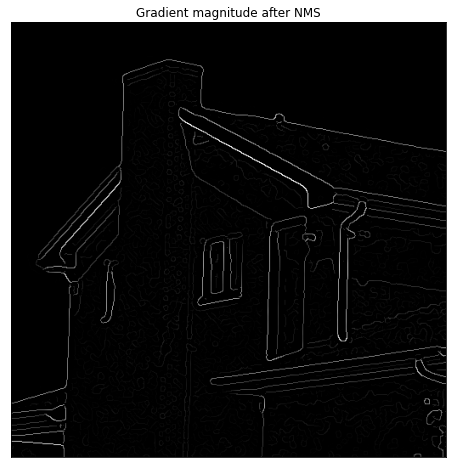

In [598]:
magnitude = suppress_nonmaximal_recalls2(magnitude, angle)

visualize_grad_magnitude(magnitude, 'Gradient magnitude after NMS')

#### 2.6. Uspoređivanje s dva praga - histereza

In [599]:
def lower_upper_threshold(magnitude, lower_threshold, upper_threshold):
    res = np.zeros(shape=magnitude.shape)
    hard_edges = np.zeros(shape=magnitude.shape)
    max_val = 255
    
    set_boundary = lambda x, m: max(min(x, m), 0)
    x_max, y_max = magnitude.shape
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            p = magnitude[i, j]

            if p < lower_threshold:
                continue
            
            if p >= upper_threshold:
                res[i, j] = max_val
                hard_edges[i, j] = max_val
                continue
            
            l = (set_boundary(i-1, x_max), set_boundary(i+2, x_max))
            h = (set_boundary(j-1, y_max), set_boundary(j+2, y_max))
            
            window = magnitude[l[0]:l[1], h[0]:h[1]]
            if window.max() >= upper_threshold:
                res[i, j] = max_val
                
    return res, hard_edges

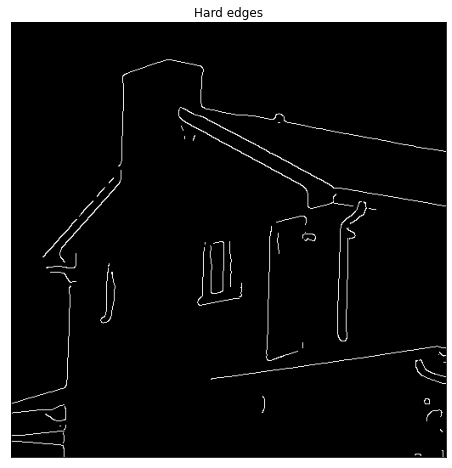

In [600]:
magnitude, hard_edges = lower_upper_threshold(magnitude, HOUSE_MIN_VAL, HOUSE_MAX_VAL)

visualize_grad_magnitude(hard_edges, 'Hard edges')

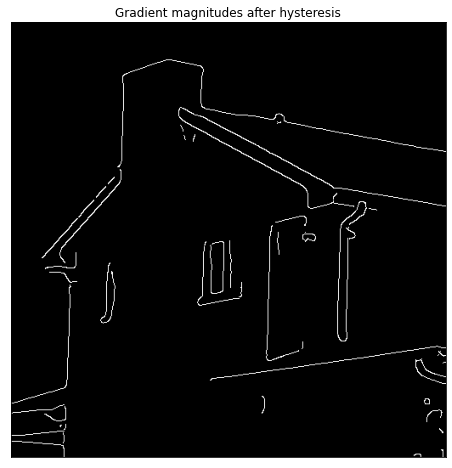

In [601]:
visualize_grad_magnitude(magnitude, 'Gradient magnitudes after hysteresis')